# Estimating Solubility from Molecular Structure

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Descriptors

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

# Read file- Delaney ESOL (Estimated Solubility Data)

In [2]:
df = pd.read_csv('Delaney.csv')
df.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


# Convert SMILES into RDKit object/Molecules List

In [3]:
mol_list = [Chem.MolFromSmiles(smile) for smile in df['SMILES']]
print("Total Number of Molecules:", len(mol_list))
mol_list[:3]

Total Number of Molecules: 1144


# List of 200 Descriptors present in RDKit

In [4]:
Descriptors_List = [x[0] for x in Descriptors._descList]  # x[0] because the 1st index gives the
print(len(Descriptors_List))                              # descriptor name, x[1]-->object loc
Descriptors_List

200


['MaxEStateIndex',
 'MinEStateIndex',
 'MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_VSA8',
 'SMR_VSA9',
 'SlogP_VSA1',
 'SlogP_VSA10',
 'SlogP_VSA11',
 'SlogP_VSA12',
 'SlogP_VSA2',
 'SlogP_VSA3',
 'SlogP_VSA4',
 'SlogP_V

# Choose Four Descriptors from RDKit
## 1) cLogP (Octanol-Water Partition Coefficient)
## 2) MW (molecular weight)
## 3) RB (number of rotatable bonds)
## 4) AP (Aromaatic Proportion = # Aromatic Atoms/# Heavy atoms)


# Function to Create a DataFrame with cLogP, MW and RB

In [5]:
def descriptors_generator(smiles):
    
    # Create RDKit Objects from SMILES data
    molData = []
    for smile in smiles:
        mol = Chem.MolFromSmiles(smile)
        molData.append(mol)
    
    # Create an empty array of shape (0x3), 3 columns = 3 descriptors-cLogp, MW, RB
    array = np.empty((0,3))
    
    # Generate Descriptors 
    for mol in molData:
        MolLogP = Descriptors.MolLogP(mol)
        MolWt = Descriptors.MolWt(mol)
        MolRB = Descriptors.NumRotatableBonds(mol)
        
        row = np.array([MolLogP, MolWt, MolRB])
        
        data = np.vstack((array, row))
        array = data
        
    columnNames = ['cLogP', 'MolWt', 'Num_RotatableBonds']    
    descriptors = pd.DataFrame(data = array, columns = columnNames)
    
    return descriptors           
    

In [6]:
desc1 = descriptors_generator(df['SMILES'])
desc1

,cLogP,MolWt,Num_RotatableBonds
0,2.59540,167.850,0.0
1,2.37650,133.405,0.0
2,2.59380,167.850,1.0
3,2.02890,133.405,1.0
4,2.91890,187.375,1.0
...,...,...,...
1139,1.98820,287.343,8.0
1140,3.42130,286.114,2.0
1141,3.60960,308.333,4.0
1142,2.56214,354.815,3.0


# Create the 4th Descriptor - Aromatic Proportion (AP)

## Get Number of Aromatic Atoms from mol_list

In [7]:
def aromaticAtoms(molList):
    AromaticAtomsCount = []
    
    for mol in molList:
        aromatic_atoms = [mol.GetAtomWithIdx(i).GetIsAromatic() for i in range(mol.GetNumAtoms())]
        #print(aromatic_atoms)
        sum = 0
        for item in aromatic_atoms:
            if item == True:
                sum+=1
        #print (sum)    
        AromaticAtomsCount.append(sum)
        
    return AromaticAtomsCount    

In [8]:
desc_AromaticAtoms = aromaticAtoms(mol_list)
desc_AromaticAtoms

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 6,
 0,
 0,
 6,
 10,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 10,
 6,
 0,
 10,
 0,
 14,
 0,
 0,
 14,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 12,
 10,
 14,
 6,
 10,
 10,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 0,
 12,
 12,
 12,
 12,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 6,
 6,
 12,
 12,
 6,
 0,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 10,
 0,
 6,
 12,
 12,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 12,
 12,
 6,
 10,
 6,
 6,
 6,
 12,
 10,
 14,
 10,
 10,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 12,
 0,
 10,
 6,
 0,
 6,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 6,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 14,
 0,

# Get Heavy Atom List

In [9]:
desc_HeavyAtoms = [Descriptors.HeavyAtomCount(mol) for mol in mol_list]
desc_HeavyAtoms

[6,
 5,
 6,
 5,
 8,
 4,
 4,
 8,
 10,
 10,
 10,
 9,
 9,
 10,
 10,
 10,
 9,
 9,
 9,
 8,
 8,
 4,
 8,
 4,
 5,
 8,
 8,
 10,
 12,
 4,
 9,
 9,
 9,
 15,
 8,
 4,
 8,
 8,
 5,
 8,
 8,
 12,
 12,
 8,
 6,
 8,
 8,
 10,
 8,
 12,
 12,
 5,
 12,
 6,
 14,
 11,
 22,
 15,
 5,
 5,
 8,
 7,
 11,
 9,
 6,
 4,
 5,
 4,
 4,
 4,
 5,
 5,
 8,
 7,
 11,
 6,
 4,
 11,
 10,
 13,
 12,
 8,
 7,
 7,
 17,
 7,
 6,
 7,
 6,
 5,
 8,
 11,
 4,
 7,
 14,
 11,
 15,
 9,
 11,
 11,
 13,
 6,
 10,
 9,
 9,
 19,
 9,
 8,
 8,
 16,
 6,
 5,
 5,
 9,
 4,
 15,
 22,
 20,
 18,
 20,
 18,
 16,
 19,
 19,
 18,
 17,
 17,
 18,
 16,
 7,
 18,
 18,
 16,
 17,
 8,
 9,
 16,
 7,
 6,
 7,
 8,
 6,
 14,
 18,
 19,
 18,
 17,
 17,
 16,
 11,
 11,
 15,
 15,
 10,
 8,
 11,
 15,
 10,
 10,
 11,
 9,
 6,
 6,
 12,
 7,
 8,
 15,
 15,
 10,
 15,
 10,
 10,
 16,
 9,
 8,
 8,
 8,
 7,
 9,
 8,
 13,
 14,
 14,
 9,
 12,
 9,
 8,
 13,
 14,
 12,
 15,
 11,
 11,
 4,
 8,
 5,
 5,
 8,
 6,
 9,
 13,
 5,
 11,
 8,
 4,
 8,
 6,
 11,
 8,
 7,
 9,
 9,
 7,
 9,
 12,
 9,
 8,
 8,
 7,
 7,
 11,
 7,
 4,
 10,
 12,
 5,

# Compute Aromatic Proportion (AP) and convert into DataFrame

In [10]:
AromaticProportion = list(map(lambda x,y: x/y, desc_AromaticAtoms, desc_HeavyAtoms))
AromaticProportion

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6,
 0.6,
 0.6,
 0.6666666666666666,
 0.6666666666666666,
 0.6,
 0.6,
 0.6,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.75,
 0.75,
 0.0,
 0.75,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6,
 0.5,
 0.0,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.4,
 0.75,
 0.0,
 0.75,
 0.75,
 0.0,
 0.0,
 0.75,
 0.8333333333333334,
 0.5,
 0.75,
 0.0,
 0.75,
 0.75,
 0.6,
 0.75,
 0.8333333333333334,
 0.5,
 0.0,
 0.8333333333333334,
 0.0,
 1.0,
 0.0,
 0.0,
 0.9333333333333333,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.8333333333333334,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.8571428571428571,
 0.9090909090909091,
 0.9333333333333333,
 0.6666666666666666,
 0.9090909090909091,
 0.9090909090909091,
 0.7692307692307693,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0

In [11]:
df_AromaticProportion = pd.DataFrame(data = AromaticProportion, columns = ['AP'])
df_AromaticProportion.head()

,AP
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


# Get All Four Descriptors in One DataFrame - X matrix

In [12]:
desc1.head()

,cLogP,MolWt,Num_RotatableBonds
0,2.5954,167.850,0.0
1,2.3765,133.405,0.0
2,2.5938,167.850,1.0
3,2.0289,133.405,1.0
4,2.9189,187.375,1.0


In [13]:
df_AromaticProportion.head()

,AP
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [14]:
X = pd.concat([desc1, df_AromaticProportion], axis=1)
X.head()

,cLogP,MolWt,Num_RotatableBonds,AP
0,2.5954,167.850,0.0,0.0
1,2.3765,133.405,0.0,0.0
2,2.5938,167.850,1.0,0.0
3,2.0289,133.405,1.0,0.0
4,2.9189,187.375,1.0,0.0


# Create Y-matrix (Measured Solubility)

In [15]:
Y = df["measured log(solubility:mol/L)"]
Y.head()

0   -2.18
1   -2.00
2   -1.74
3   -1.48
4   -3.04
Name: measured log(solubility:mol/L), dtype: float64

In [16]:
Descriptors =  pd.concat([X, Y], axis=1)
Descriptors = Descriptors.rename(columns = {'measured log(solubility:mol/L)': 'LogS'})
Descriptors.head()

,cLogP,MolWt,Num_RotatableBonds,AP,LogS
0,2.5954,167.850,0.0,0.0,-2.18
1,2.3765,133.405,0.0,0.0,-2.00
2,2.5938,167.850,1.0,0.0,-1.74
3,2.0289,133.405,1.0,0.0,-1.48
4,2.9189,187.375,1.0,0.0,-3.04


In [17]:
Descriptors.to_csv('Descriptors.csv')

# Model Using sklearn Linear Regression

### Train/Test Split

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2)

### Fit model

In [19]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression()

### Get Coefficents and Intercept

In [20]:
print(lr.coef_)

[-0.75140478 -0.00688189  0.00502562 -0.34965642]


In [21]:
print(X.columns)

Index(['cLogP', 'MolWt', 'Num_RotatableBonds', 'AP'], dtype='object')


In [22]:
pd.DataFrame(data = [lr.coef_], columns = X.columns)

## NOTE : data = [model.coef_]i.e. [[-0.751,0-0.00688, 0.005026, -0.3496]]

,cLogP,MolWt,Num_RotatableBonds,AP
0,-0.751405,-0.006882,0.005026,-0.349656


In [23]:
print(lr.intercept_)

0.29520659388797243


### Get Train and Test Scores (R^2 score)

In [24]:
print(lr.score(X_train, Y_train))

0.7765805143879706


In [25]:
print(lr.score(X_test, Y_test))

0.7418557723283168


### Get RMSE on Test Data

In [26]:
from math import sqrt

Y_predict = lr.predict(X_test)

RMSE = sqrt(mean_squared_error(Y_test, Y_predict))
print('The RMSE on Test data is:', RMSE)

The RMSE on Test data is: 1.077647028373618


### Model Fit on Full Data Set

In [27]:
full_lr = LinearRegression()
full_lr.fit(X,Y)

LinearRegression()

In [28]:
full_lr_coeff = pd.DataFrame([full_lr.coef_], columns=X.columns, index = ['Coefficients'])
full_lr_coeff

,cLogP,MolWt,Num_RotatableBonds,AP
Coefficients,-0.741736,-0.006599,0.003201,-0.423164


In [29]:
print(full_lr.intercept_)

0.2565006830997203


### Regression Equation

In [30]:
print('LogS = %0.4f %0.4fLogP %0.4fMW +%0.4fRB %0.4fAP' %(full_lr.intercept_, full_lr.coef_[0],
                                                        full_lr.coef_[1], full_lr.coef_[2],
                                                        full_lr.coef_[3]))

LogS = 0.2565 -0.7417LogP -0.0066MW +0.0032RB -0.4232AP


### Performance Metrics on Full Dataset

In [31]:
print('R2 Score Full Data:', full_lr.score(X,Y))

R2 Score Full Data: 0.7700996708062849


In [32]:
Y_pred_full = full_lr.predict(X)
print('RMSE Score Full Data:', sqrt(mean_squared_error(Y_pred_full, Y)))

RMSE Score Full Data: 1.0047896800566531


### Plot Y_predict vs Y_true

Text(0, 0.5, 'Predicted Solubilty')

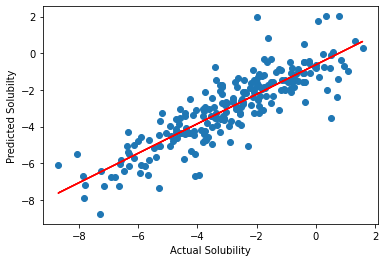

In [33]:
# Scatter PLot
plt.scatter(x = Y_test, y = Y_predict)

# Add Trendline on matplotlib scatter plot
z = np.polyfit(Y_test, Y_predict, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test), 'r')

# Add x,y labels
plt.xlabel('Actual Solubility')
plt.ylabel('Predicted Solubilty')

# Model Using statsmodels OLS

### Fit Model

In [34]:
X = sm.add_constant(X)
ols = sm.OLS(Y,X).fit()
print(ols.summary())

                                  OLS Regression Results                                  
Dep. Variable:     measured log(solubility:mol/L)   R-squared:                       0.770
Model:                                        OLS   Adj. R-squared:                  0.769
Method:                             Least Squares   F-statistic:                     953.8
Date:                            Sun, 10 Jan 2021   Prob (F-statistic):               0.00
Time:                                    19:18:32   Log-Likelihood:                -1628.7
No. Observations:                            1144   AIC:                             3267.
Df Residuals:                                1139   BIC:                             3293.
Df Model:                                       4                                         
Covariance Type:                        nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---

### Partial Regression Plots

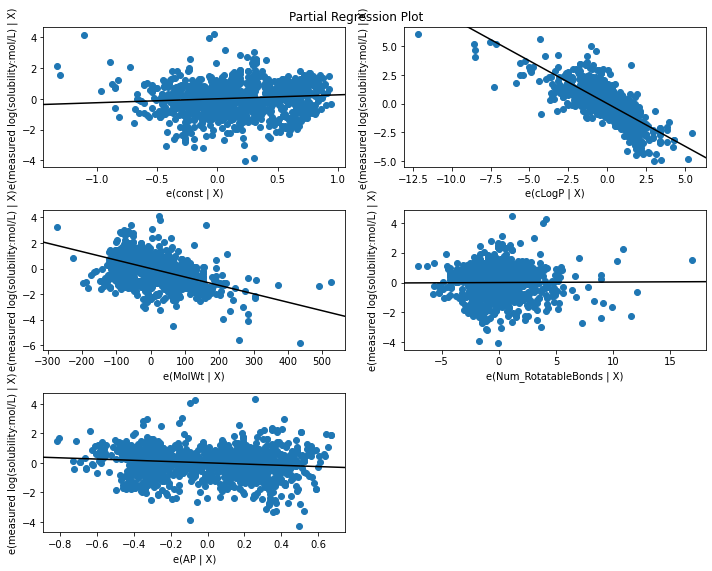

In [35]:
fig = plt.figure(figsize=(10,8))
fig = sm.graphics.plot_partregress_grid(ols,fig=fig)

### Predicted Solubility

In [36]:
Y_pred_OLS = ols.predict(X)

### Predicted Vs True solubility

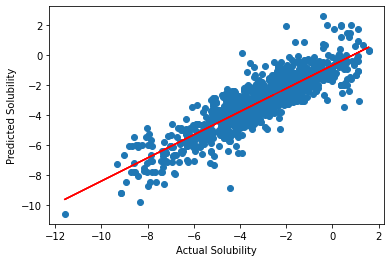

In [37]:
plt.scatter(Y, Y_pred_OLS)
plt.xlabel('Actual Solubility')
plt.ylabel('Predicted Solubility')

# Add Trendline

z = np.polyfit(Y, Y_pred_OLS, 1)
p = np.poly1d(z)
plt.plot(Y, p(Y), 'r')

In [38]:
compare = sm.OLS(Y, Y_pred_OLS).fit()
print(compare.summary())

                                       OLS Regression Results                                      
Dep. Variable:     measured log(solubility:mol/L)   R-squared (uncentered):                   0.927
Model:                                        OLS   Adj. R-squared (uncentered):              0.926
Method:                             Least Squares   F-statistic:                          1.442e+04
Date:                            Sun, 10 Jan 2021   Prob (F-statistic):                        0.00
Time:                                    19:18:33   Log-Likelihood:                         -1628.7
No. Observations:                            1144   AIC:                                      3259.
Df Residuals:                                1143   BIC:                                      3265.
Df Model:                                       1                                                  
Covariance Type:                        nonrobust                                                  
